In [279]:
# NBA Data Clustering and MVP Share Regression - Author: Mahmoud Zahran 

# Introduction (source: https://www.britannica.com/sports/basketball/Play-of-the-game)

# Basketball is a sport that was invented by James Naismith in 1891 at the International Young Men’s Christian Association (YMCA) Training School in Massachusetts. 
# On a rectangular court featuring two teams, each consisting of five players, the teams compete to score as many points as possible.
# Points are achieved by scoring goals through a basket (horizontal hoop mounted at a height of 10 feet), but there are rules that dictate how many points should
# be allotted to the scoring team based on the goal was scored (depends on the distance from the basket at the time of taking the shot).
# The court is characterized by some markings on the ground. Namely, a center circle where the ball is tossed vertically at the start of each quarter 
# (so that the team that grabs the ball first has the advantage because they get to attack first), free throw lanes at each side of the court,
# as well as a three-point line. 

In [280]:
# Teams are made up of two forwards, two guards, and a center. Players may bounce/dribble the ball or pass it to a teammate while moving through the court, closer to their 
# opponent’s basket, so that they could attempt to score through the basket. 
# Fouls are committed in cases where illegal contact (e.g., grabbing, pushing, slamming, etc.) is made with a player from the opposing team.
# Fouls could be offensive, defensive, flagrant, and technical depending on where and how they happen. In the case where a player is fouled while attempting a shot on
# the opponent’s basket and they end up scoring that attempt, the attempt is counted, along with an additional free throw. A free throw is essentially a throw from 
# behind the free/foul line that’s undefended by the opposing team. Should a fouled player miss their awarded free throw in the case discussed above, they’re awarded 
# a second free throw. As referred to above, there are different types of fouls, and they’re not only restricted to free throw opportunities (could also award position
# to the fouled team). To learn more about types of fouls and where they apply, visit https://www.britannica.com/sports/basketball/Play-of-the-game. 

In [315]:
# In this project, we’re importing NBA data through Kaggle to perform some exploratory analysis using unsupervised Machine Learning techniques to better understand the data
# and recognize any patterns that might be featured in the data (exploratory analysis). 
# Specifically, we’re using the KMeans clustering unsupervised machine learning model to reach insights into how
# the data tends to be clustered, given some chosen metrics that are a subset of the all the features present in the data. Aside from having an enhanced interpretability of the
# data, clustering applications have many applications that could also apply as transfer learning for use in supervised learning algorithms and models. 
# The metrics/statistics used in clustering the data are the Assists Per Game (AST), Points Per Game (PTS), and Rebounds Per Game (REB). The AST and PST statistics are self-explanatory
# but in terms of RPG, it’s essentially a count of how many times a player is the first to grab the ball after a scoring attempt, either while defending or attacking.

# In addition to performing KMeans clustering on the NBA data (using rebounds, points, and assists), we're going to employ supervised machine learning in hopes of training a model 
# to predict the MVP (Most Valuable Player) of a given season. Some features like win shares, total games, assists, rebounds, and blocks (among many others) are used in training 
# a regressor for estimating the mvp award shares for players. 

# Notably, for the supervised learning part of the project, I did some webscraping from basketball-reference.com to retrieve the datasets (since they're not available for downloading on their
# website). This is done in a separate notebook.

# Data source: https://www.kaggle.com/datasets/wyattowalsh/basketball?datasetId=1218020&sortBy=dateRun&tab=profile


# Some other similar projects that are useful to look at:
# 1. https://github.com/duartevfreire/nbamvp
# 2. https://towardsdatascience.com/predicting-2020-21-nbas-most-valuable-player-using-machine-learning-24aaa869a740
# 3. https://towardsdatascience.com/3-d-clustering-of-nba-players-with-plotly-and-k-means-6ee7644f2a6c

In [282]:
!pip install yellowbrick
!pip install plotly

import plotly.io as pio
import warnings
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
import requests
from bs4 import BeautifulSoup
import random
from sklearn.model_selection import cross_val_score, train_test_split,  GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [283]:
# First, we begin by importing the data as a pandas dataframe, using pandas's read_sql function. 

# The name of the sql file containing the NBA data. 
basketball_sqlite_file = 'basketball.sqlite'

# Establishing a connection with the sql file SQL's connect function. 
connection = sql.connect(basketball_sqlite_file)

# SQL query for extracting the Player_Attributes table from the SQL file. Using the "SELECT" command allows to filter/select data from the database.
# For our purposes, we'd like to extract everything form the Player_Attributes table in the database, which is why we're using the '*' (selects everything). 
extract_player_attributes_query = 'SELECT * FROM Player_Attributes'

# We can use pandas's read_sql function, along with the connection established with the SQL file, to read from the database with the help of some query. 
# In this case, we're using the query defined above, which is extracting all rows and columns from the Player_Attributes table. 
player_attributes_df = pd.read_sql(extract_player_attributes_query, connection)

player_attributes_df

,ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,...,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
0,76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24T00:00:00,Duke,USA,...,Y,Y,1990,1,25,5.7,0.3,3.3,0.0,NaN
1,76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07T00:00:00,Iowa State,USA,...,Y,Y,1968,1,5,9.0,1.2,8.0,0.0,NaN
2,76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16T00:00:00,UCLA,USA,...,Y,Y,1969,1,1,24.6,3.6,11.2,18.0,NaN
3,51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09T00:00:00,Louisiana State,USA,...,Y,Y,1990,1,3,14.6,3.5,1.9,0.0,NaN
4,1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03T00:00:00,San Jose State,France,...,Y,Y,1997,1,11,7.8,1.1,3.3,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1627790,Ante,Zizic,Ante Zizic,"Zizic, Ante",A. Zizic,ante-zizic,1997-01-04T00:00:00,,Croatia,...,Y,Y,2016,1,23,6.0,0.6,3.9,0.0,NaN
4496,78647,Jim,Zoet,Jim Zoet,"Zoet, Jim",J. Zoet,jim-zoet,1953-12-30T00:00:00,Kent State,USA,...,Y,Y,Undrafted,Undrafted,Undrafted,0.3,0.1,1.1,0.0,NaN
4497,78648,Bill,Zopf,Bill Zopf,"Zopf, Bill",B. Zopf,bill-zopf,1948-06-07T00:00:00,Duquesne,USA,...,Y,Y,1970,2,33,2.2,1.4,0.9,0.0,NaN
4498,1627826,Ivica,Zubac,Ivica Zubac,"Zubac, Ivica",I. Zubac,ivica-zubac,1997-03-18T00:00:00,Mega Basket,Croatia,...,Y,Y,2016,2,32,8.5,1.1,7.0,NaN,0.126


In [284]:
# Inspecting the column names available in the dataframe. 
player_attributes_df.columns

Index(['ID', 'FIRST_NAME', 'LAST_NAME', 'DISPLAY_FIRST_LAST',
       'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FI_LAST', 'PLAYER_SLUG',
       'BIRTHDATE', 'SCHOOL', 'COUNTRY', 'LAST_AFFILIATION', 'HEIGHT',
       'WEIGHT', 'SEASON_EXP', 'JERSEY', 'POSITION', 'ROSTERSTATUS',
       'GAMES_PLAYED_CURRENT_SEASON_FLAG', 'TEAM_ID', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'TEAM_CODE', 'TEAM_CITY', 'PLAYERCODE',
       'FROM_YEAR', 'TO_YEAR', 'DLEAGUE_FLAG', 'NBA_FLAG', 'GAMES_PLAYED_FLAG',
       'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER', 'PTS', 'AST', 'REB',
       'ALL_STAR_APPEARANCES', 'PIE'],
      dtype='object')

In [285]:
# To perform the unsupervised learning exploratory analysis and be able to cluster the data, we're selecting a subset of the features 
# that we're going to use to cluster the data. As referred to earlier, we're going to use the Points Per Game (PTS), Rebounds Per Game
# (REB), and Assists Per Game (AST) statistics to cluster the data. 
dimensions = ['PTS','REB','AST']

# Now, we'd like to inspect if there are any null entries in the data (as that would cause issues while running the KMeans model and 
# when visualizing the data). 
player_attributes_df[dimensions].isna().sum()

PTS     15
REB    307
AST     15
dtype: int64

In [286]:
# Dropping all null observations from the data using pandas's dropna method. 
clustering_df = player_attributes_df[dimensions].dropna()

clustering_df

,PTS,REB,AST
0,5.7,3.3,0.3
1,9.0,8.0,1.2
2,24.6,11.2,3.6
3,14.6,1.9,3.5
4,7.8,3.3,1.1
...,...,...,...
4494,4.7,2.6,0.8
4495,6.0,3.9,0.6
4496,0.3,1.1,0.1
4497,2.2,0.9,1.4


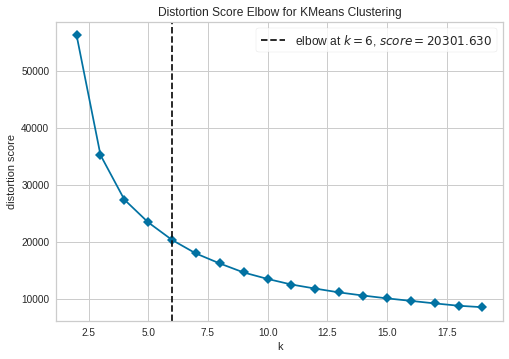

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [287]:
# Initializing the KMeans model and cucstomizing some of the parameters. 
# Specifying ‘k-means++’ for the 'init' parameter speeds up the model's convergenece because it uses sampling that depends 
# on an empirical probability distribution of how each centroid contributes to the overall inertia (incorporates a bunch of trials
# for picking centroids to find the optimal one for minimizing the overall inertia). 

# As for 'n_init', it represents the number of times that KMeans will be run using different centroid seeds. After running that many 
# iterations, we pick the 'best' iteration that results in centroid assignments that minimize inertia as much as possible.

# For 'max_iter', it defines the maxmimum number of iterations involved while KMeans is running. That is, by the time that many 
# iterations are run, if the algorithm hadn't converged to a fixed point, we halt KMeans at that point. 
km_model = KMeans(init='k-means++', n_init = 12, max_iter = 100)

# Notably, one drawback of the KMeans clustering algorithm is that it already requires a specification of the k value prior to being 
# run (it requires the user of the algorithm to specify how many clusters are available in the data). However, we often don't know 
# and cannot assume a specific value for k, as we don't know the optimal value for it given the data.
# For that reason, we use an 'elbow visualizer' to help with identifying that optimal k value. 
# We use a range of potential k values. For each value in that range, we use it to run the algorithm and compute the distortion score (aka inertia)
# for that run, which is essentially the sum of the squared distances between each datapoint and its corresponding centroid assignment. 
# Intuitively, as the k hyperparameter approaches n (the number of datapoints available in the space), the distortion approaches 0. Using this intuition,
# we can see that there's a tradeoff involving distortion and the k hyperparameter. Specifically, we're interested in minimizing distortion while 
# simultaneously maintaining a low value for k. Given a plot of distortion scores for each of the k values in the selectd range, we could identify a k value 
# that marks an 'elbow' such that greater k values don't yield a significant gradient in distortion, which is what this KElbowVisualizer instance does. 

# In this case, we set the range of k values to be [2, 20). 
elbow_visualizer = KElbowVisualizer(km_model, k=(2,20), timings=False, random_state=42)

# Fitting the elbow visualizer using our clustering dataframe. 
elbow_visualizer.fit(clustering_df)    

# Drawing/showing the data. 
elbow_visualizer.poof()

In [288]:
# Following the elbow visualization step and determining the optimal k value, we can now run k means to cluster the data. 
# However, the features used for clustering have different ranges of values associated with them, which impacts the 
# performance of the model as the weights aren't balanced. Therefore, prior to clustering the data, we scale them using 
# a standard scaler. 
scaler = StandardScaler()

# unscaled clustering dataframe -> scaled clustering dataframe. 
# We simply construct a new dataframe whose data is now scaled, with a slight modification done to each of the column names 
# (adding 'scaled_' as a prefix). 
scaled_clustering_df = pd.DataFrame(data=scaler.fit_transform(clustering_df), \
                                    columns=['scaled_{column}'.format(column=col) for col in clustering_df.columns])

scaled_clustering_df

,scaled_PTS,scaled_REB,scaled_AST
0,-0.158972,0.139181,-0.819011
1,0.500878,2.193603,-0.192272
2,3.620170,3.592358,1.479032
3,1.620624,-0.472774,1.409394
4,0.260933,0.139181,-0.261909
...,...,...,...
4188,-0.358926,-0.166796,-0.470822
4189,-0.098985,0.401448,-0.610098
4190,-1.238726,-0.822463,-0.958286
4191,-0.858813,-0.909885,-0.052996


In [289]:
# Now, we can update our KMeans model given our optimal k (elbow) value. At this point, we're ready to train it using the scaled 
# dataframe obtained above. 
km_model = KMeans(n_clusters=elbow_visualizer.elbow_value_, init='k-means++', n_init = 12, max_iter = 100).fit(scaled_clustering_df)

# Using the label mappings (aka cluster assignments) given to each datapoint after running the algorithm to construct a new column in 
# the clustering dataframe. 
clustering_df['cluster_assignments'] = km_model.labels_

scaled_clustering_df

,scaled_PTS,scaled_REB,scaled_AST
0,-0.158972,0.139181,-0.819011
1,0.500878,2.193603,-0.192272
2,3.620170,3.592358,1.479032
3,1.620624,-0.472774,1.409394
4,0.260933,0.139181,-0.261909
...,...,...,...
4188,-0.358926,-0.166796,-0.470822
4189,-0.098985,0.401448,-0.610098
4190,-1.238726,-0.822463,-0.958286
4191,-0.858813,-0.909885,-0.052996


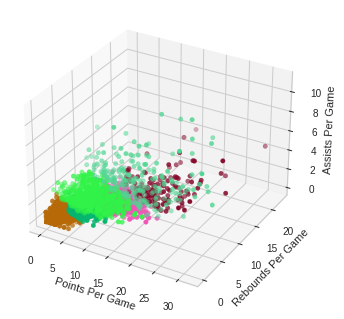

In [290]:
# For this step, we're now ready to create a 3D visualization using the PTS, AST, and REB stats because we have the cluster assignment/label 
# for each datapoint in the space. 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extracting the optimal (elbow) k value from the elbow visualizer as this represents the number of clusters available naturally in the data. 
# We do this because we're going to generate random hex color codes to color the datapoints. 
num_clusters = elbow_visualizer.elbow_value_

# Using random's randint function that returns a random int in the specified range to generate random hex color codes. We format the random int
# we got from randint as a sequence of 6 hexadecimal digits, and then convert these to uppercase where
# applicable, which gets us to the final result (something that looks like #0000FF). As a result, we now have a list of colors of size 'num_clusters'
# so that we can color all clusters using distinct colors. 
colors = []
while len(colors) < num_clusters:
    rand_color_code = '#%06x'.upper() % random.randint(0, 0xFFFFFF)
    if rand_color_code not in colors:
        colors.append(rand_color_code)

# Designating a dictionary that maps each cluster number to the cluster's corresponding datapoints (the ones that were assigned to it). 
# We're going to use this to visualize and color the clusters. 
cluster_dict = {}

# Now, we iterate over each cluster number, map that cluster number to its corresponding observations, and scatter the cluster's data 
# using its corresponding random color generated earlier. 
for cluster_num in range(num_clusters):
    
    # Filtering cluster-specific data. 
    cluster = clustering_df.loc[clustering_df['cluster_assignments'] == cluster_num]
    
    # Mapping cluster number to the filtered dataframe.
    cluster_dict[cluster_num] = cluster
    
    # Drawing the data as in a scatterplot. 
    ax.scatter(xs=cluster['PTS'],ys=cluster['REB'],zs=cluster['AST'],color=colors[cluster_num])
    
# Customizing the x,y, and z labels and showing the final visualization. 
ax.set_xlabel('Points Per Game')
ax.set_ylabel('Rebounds Per Game')
ax.set_zlabel('Assists Per Game')
plt.show()

In [291]:
# After plotting the clustered data, we would like to inspect and numerically interpret the attributes and average values of each cluster.
# To that end, we group the elements in the clustering dataframe using the mean of each of the cluster assignments. 
mean_cluster_data = clustering_df.groupby(by='cluster_assignments').mean()

# Renaming the columns after the grouping to reflect the new data (averages). 
mean_cluster_data.columns = map(lambda column_name: 'CLUSTER_AVG_{column}'.format(column=column_name), mean_cluster_data.columns)

# Computing a 'TOTAL' metric, which is basically the sum of the cluster average stats. This is going to be used as a proxy for measuring
# the average performance of the cluster, and is going to be used to sort the dataframe in descending order. 
for index, row in mean_cluster_data.iterrows():
    mean_cluster_data.at[index, 'TOTAL'] = mean_cluster_data.iloc[index, :].sum()

# Sorting the dataframe inplace and in descending order, using the TOTAL metric. 
mean_cluster_data.sort_values(by='TOTAL', ascending=False, inplace=True)
mean_cluster_data

,CLUSTER_AVG_PTS,CLUSTER_AVG_REB,CLUSTER_AVG_AST,TOTAL
cluster_assignments,,,,
5,17.246053,9.916447,2.571711,29.734211
1,16.781780,4.035169,5.383898,26.200847
3,10.547619,5.929714,1.592952,18.070286
2,8.442649,2.347658,2.865105,13.655412
4,5.747521,3.414463,0.921178,10.083161
0,2.554460,1.282162,0.606202,4.442823


In [292]:
# As we can see from the data displayed in this dataframe, our NBA data tends to be clustered in 6 groups when it comes 
# to the AST, PTS, and REB stats, with varying performance levels across these groups. On the one hand, we have 'high-achieving'
# groups like clusters 5 and 3 (with total cluster average sums of 29.734211 and 26.206867 respectively). On the other hand, groups 
# like 0 and 4 seem to be underperforming significantly. 

# Even though these metrics give only a partial image of the players' performance, they span all aspects and player positions in the court.
# That is to say, these metrics aren't exclusively about a particular subpopulation (e.g., forward players), because they indicate both 
# offensive and defensive performance (e.g., offensive -> AST + PTS, defensive -> REB). That said, they might favor offensive positions a 
# bit more as rebounds could also happen in offensive positions (so offensive is really -> AST + PTS + REB). 

In [293]:
# In this next part, we implement supervised learning to train multiple regressors (e.g., deep neural network, knn regressor, etc.). 
# for MVP (Most Valuable Player) share estimation. There are some challenges to doing this, however, because of the limited quantity of 
# training data available to us, along with the nature of MVP Shares involving a fair amount of subjectivity/bias. Despite that, I speculate
# that Win Share (WS, which signifies the extent to which team wins are attributed to the player) is the most crucial feature when it comes to MVP Awards.
# In this project, we're going to try to examine this hypothesis by looking at feature importances after performing the regression. 

# For more information about Win Share, visit: https://www.basketball-reference.com/about/ws.html

In [294]:
# To begin with, we import this csv that contains data about all MVP candidates in all seasons starting from the 1955-56 season
# (i.e., stats like points and rebound averages, MVP share, etc.).

# Reading the csv.
mvp_data = pd.read_csv('mvps_w_share_df.csv')

print(mvp_data.columns)
mvp_data

Index(['Season', 'Rank', 'Player', 'Age', 'Tm', 'First', 'Pts Won', 'Pts Max',
       'Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%',
       'FT%', 'WS', 'WS/48'],
      dtype='object')


,Season,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,...,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2021-22,1,Nikola Jokić,26,DEN,65.0,875.0,1000,0.875,74,...,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
1,2021-22,2,Joel Embiid,27,PHI,26.0,706.0,1000,0.706,68,...,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252
2,2021-22,3,Giannis Antetokounmpo,27,MIL,9.0,595.0,1000,0.595,67,...,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281
3,2021-22,4,Devin Booker,25,PHO,0.0,216.0,1000,0.216,68,...,26.8,5.0,4.8,1.1,0.4,0.466,0.383,0.868,7.6,0.156
4,2021-22,5,Luka Dončić,22,DAL,0.0,146.0,1000,0.146,65,...,28.4,9.1,8.7,1.2,0.6,0.457,0.353,0.744,7.6,0.159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,1955-56,4,Mel Hutchins,27,FTW,9.0,9.0,80,0.113,66,...,12.0,7.5,2.7,NaN,NaN,0.425,NaN,0.643,4.4,0.095
1019,1955-56,5,Dolph Schayes,27,SYR,2.0,2.0,80,0.025,72,...,20.4,12.4,2.8,NaN,NaN,0.387,NaN,0.858,11.8,0.225
1020,1955-56,5,Bill Sharman,29,BOS,2.0,2.0,80,0.025,72,...,19.9,3.6,4.7,NaN,NaN,0.438,NaN,0.867,8.8,0.157
1021,1955-56,7,Tom Gola,23,PHW,1.0,1.0,80,0.013,68,...,10.8,9.1,5.9,NaN,NaN,0.412,NaN,0.733,6.5,0.132


In [295]:
# Inspecting the count of null entries in each column. 
nulls_series = mvp_data.isnull().sum()

nulls_series

Season       0
Rank         0
Player       0
Age          0
Tm           0
First        0
Pts Won      0
Pts Max      0
Share        0
G            0
MP           0
PTS          0
TRB          0
AST          0
STL        216
BLK        216
FG%          0
3P%        352
FT%          0
WS           0
WS/48        0
dtype: int64

In [296]:
# As seen above, we have quite a few observations that are missing, which is going to impede our regressors in making predictions. 
# Therefore, we drop these null values here. 
mvp_data.dropna(inplace=True)

mvp_data

,Season,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,...,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2021-22,1,Nikola Jokić,26,DEN,65.0,875.0,1000,0.875,74,...,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
1,2021-22,2,Joel Embiid,27,PHI,26.0,706.0,1000,0.706,68,...,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252
2,2021-22,3,Giannis Antetokounmpo,27,MIL,9.0,595.0,1000,0.595,67,...,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281
3,2021-22,4,Devin Booker,25,PHO,0.0,216.0,1000,0.216,68,...,26.8,5.0,4.8,1.1,0.4,0.466,0.383,0.868,7.6,0.156
4,2021-22,5,Luka Dončić,22,DAL,0.0,146.0,1000,0.146,65,...,28.4,9.1,8.7,1.2,0.6,0.457,0.353,0.744,7.6,0.159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,1979-80,5,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,...,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148
693,1979-80,5,Dennis Johnson,25,SEA,2.0,2.0,221,0.009,81,...,19.0,5.1,4.1,1.8,1.0,0.422,0.207,0.780,7.4,0.120
694,1979-80,5,Dan Roundfield,26,ATL,2.0,2.0,221,0.009,81,...,16.5,10.3,2.3,1.2,1.7,0.499,0.000,0.710,9.1,0.169
695,1979-80,8,Gus Williams,26,SEA,1.5,1.5,221,0.007,82,...,22.1,3.4,4.8,2.4,0.5,0.482,0.194,0.788,11.6,0.187


In [297]:
# For this part, we're investigating multicollinearity in the feature set by constructing a correlation matrix. Multicollinearity 
# happens when we have a subset of more than 1 feature among which there's high correlation. When that happens, it adversely impacts
# the model's performance. This is because, for these highly correlated features, we can predict some of them using others, which results in
# a biased model. Therefore, we want to handle highly correlated features to avoid multicollinearity.

correlation_matrix_features = ['Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%','FT%', 'WS', 'WS/48']
corr_mat_df = mvp_data[correlation_matrix_features]
corr_mat_df

,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,0.875,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
1,0.706,68,33.8,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252
2,0.595,67,32.9,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281
3,0.216,68,34.5,26.8,5.0,4.8,1.1,0.4,0.466,0.383,0.868,7.6,0.156
4,0.146,65,35.4,28.4,9.1,8.7,1.2,0.6,0.457,0.353,0.744,7.6,0.159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148
693,0.009,81,36.3,19.0,5.1,4.1,1.8,1.0,0.422,0.207,0.780,7.4,0.120
694,0.009,81,32.0,16.5,10.3,2.3,1.2,1.7,0.499,0.000,0.710,9.1,0.169
695,0.007,82,36.2,22.1,3.4,4.8,2.4,0.5,0.482,0.194,0.788,11.6,0.187


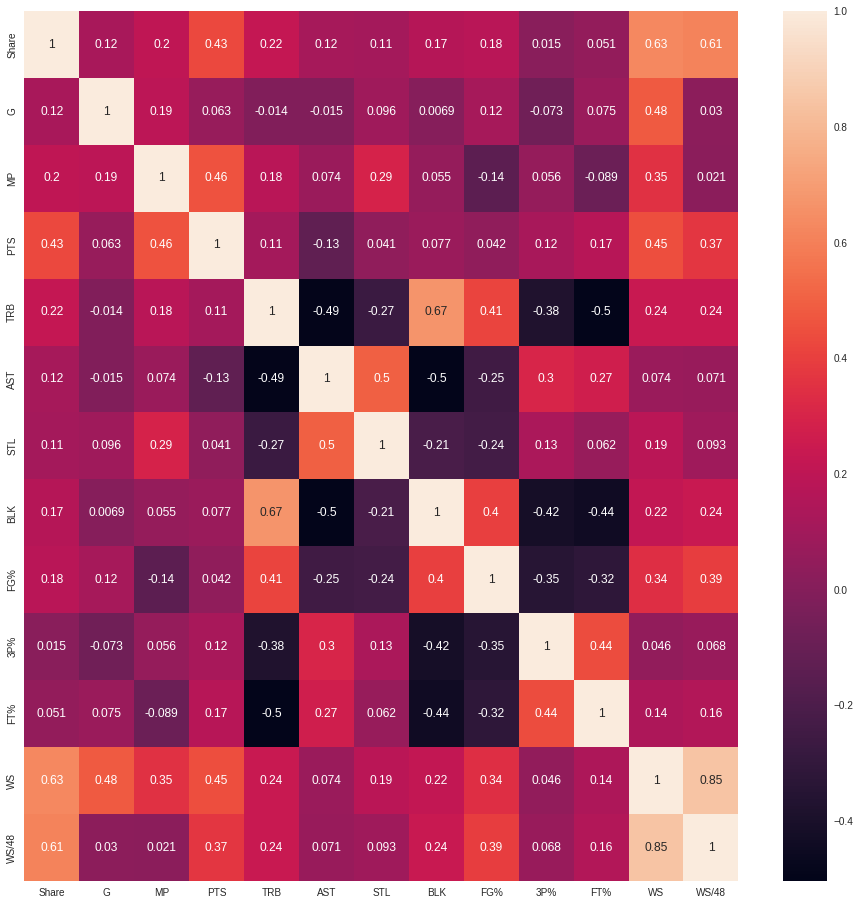

In [298]:
# Given the correlation matrix obtained above, we can visualize a heatmap to aid in readability and interpretability.
# We use seaborn's heatmap function to accomplish this. 
plt.figure(figsize=(16, 16))
sns.heatmap(corr_mat_df.corr(), annot=True)
plt.show()

In [299]:
# As seen from the heatmap above, some highly correlated features are WS and WS/48 (so we can choose only WS to 
# be featured in the data). 

In [300]:
# Defining the feature set that's going to be used in making predictions. 
features = ['G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%','FT%', 'WS']

# Setting the target feature to be the (MVP) 'Share'.
target = 'Share'

# Extracting the dataframe of independent features used to train the regressors. 
feature_df = mvp_data[features]

# Extracting the series representing the target feature (MVP Share). 
target_series = mvp_data[target]

In [301]:
# In this part, we're defining a function that takes in a regressor and a hyperparameter grid representing 
# a range of potential hyperparameter values. This function deploys grid search for tuning the hyperparameters 
# of the regressor being trained to ensure optimal performance in regression. 
def perform_grid_search(regressor, param_grid):
    
    # Instantiating an instance of the GridSearchCV class. We pass the 'regressor' parameter as the estimator 
    # for which we're tuning the hyperparameters. In addition, we also supply the hyperparameter grid, which is 
    # going to be used to perform the grid search. 
    
    # We also deploy ten-fold cross validation as the strategy for evaluating the model's performance. That is to say, 
    # for each combination of hyperparameter values specified by the hyperparameter grid, we use multiple combinations of 
    # training and testing data (10% and 90%, respectively) to perform the regression. Ten-fold cross validation ensures
    # avoiding selection bias and overfitting, which is useful for gauging how well the model might perform on unseen 
    # datasets. 
    
    # In addition, we specifiy the parameter 'n_jobs' as -1, which speeds up convergence because it means using all 
    # processes.
    gscv = GridSearchCV(estimator=regressor,\
                       param_grid=param_grid, 
                       cv=10, \
                       verbose=0,\
                       n_jobs=-1)
    
    # Fitting the GridSearchCV instance on our data. 
    fitted_over_grid = gscv.fit(feature_df, target_series)
    
    # Extracting and returning the optimal hyperparameters after performing the grid search.
    optimal_hyperparams = fitted_over_grid.best_params_
    return optimal_hyperparams

In [302]:
# This function takes in an already tuned model, and uses holdout validation for evaluating the model using 
# r2 and mean squared error scores. It returns a dictionary of evaluation metrics (namely, r2 and mse). The r2
# score measures the proportion of the variance in the dependent feature that is explainable by the independent 
# features (ranges from 0 to 1). Generally, the closer to 1 the r2 score is, the better and more statistically 
# significant the results are. 
def train_and_get_scores(tuned_model): 
    
    # Splitting the data into training and testing data (90% and 10% respectively). 
    train_x, test_x, train_y, test_y = train_test_split(feature_df, target_series, test_size=0.1, random_state=42)
    
    # Fitting the tuned model on the training data. 
    tuned_model.fit(train_x, train_y)
    
    # Predicting MVP share using the tuned and trained model.
    pred_y = tuned_model.predict(test_x)
    
    # Evaluating the r2 and mean squared error scores to evaluate the model. 
    r2 = r2_score(test_y, pred_y)
    mse = mean_squared_error(test_y, pred_y)
    
    # Returning the dictionary of evaluation metrics referred to above.
    eval_metrics = {'R2': r2, 'MSE':mse}
    return eval_metrics

In [303]:
# In this next part, we're going to finally put everything together to tune, train, and test each of the
# regression models.

# First, we're training a Random Forest Regressor. This model is similar to its classification counterpart (a 
# regular Random Forest classifier), but as the name suggests, it's used in regression applications. 

# For training the Random Forest Regressor, we first tune it using the 'perform_grid_search' function defined 
# above. After that, we construct the Random Forest Regressor with the procured optimal hyperparameters. 
# There are 2 main hyperparameters involved when it comes to Random Forest Regressors:
#      1. max_depth: the maximum depth of the tree (which could be optimized to avoid overfitting). 
#      2. n_estimators: the number of trees in the forest. These trees use different subsets of the independent 
#         features in regression, and then the results of each of these trees are combined.

# Finally, we return the tuned and trained regressor along with the r2 and mse scores. 
def get_trained_rfr_and_scores(param_grid_vals):
    optimal_hyperparams_dict = perform_grid_search(RandomForestRegressor(), param_grid=param_grid_vals)
    tuned_rfr = RandomForestRegressor(max_depth=optimal_hyperparams_dict['max_depth'],\
                                     n_estimators=optimal_hyperparams_dict['n_estimators'],\
                                      verbose=False, random_state=False)
    return tuned_rfr, train_and_get_scores(tuned_rfr)

In [304]:
# Getting the tuned rfr and printing the evaluation metrics. 
tuned_rfr, eval_metrics = get_trained_rfr_and_scores({'max_depth':range(2, 8), 'n_estimators':[5*x for x in range(1, 8)]})
print(tuned_rfr)
print(eval_metrics)

RandomForestRegressor(max_depth=5, n_estimators=15, random_state=False,
                      verbose=False)
{'R2': 0.4414965318400187, 'MSE': 0.03753873273933036}


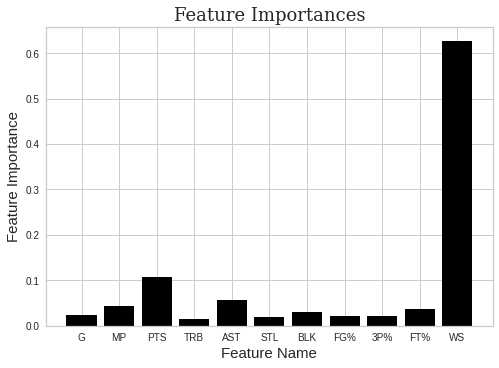

In [305]:
# Plotting a barplot of the feature importance scores for each of the features, which gives an indication of how 
# important each feature is in predicting the target (MVP Share). 
plt.bar(feature_df.columns,tuned_rfr.feature_importances_, color='black')

# Customizing the plot (setting the title along with the x and y axis labels). 
plt.title('Feature Importances', fontdict={'font':'serif', 'size':18})
plt.xlabel('Feature Name', size=15)
plt.ylabel('Feature Importance', size=15)
plt.show()

In [306]:
# As hypothesized above (rejecting the null hypothesis), Win Share is predominantly the most important 
# feature in predicting MVP Share.

In [307]:
# Calculating ten-fold cross validation scores and printing their average. 
cv_scores = cross_val_score(tuned_rfr, feature_df, target_series, cv=10)

print('Average CV score for the RFR: ', cv_scores.mean())

Average CV score for the RFR:  0.43133331866405944


In [308]:
# Repeating the same process for tuning, training, and testing a KNN Regressor. A KNN Regressor is another model
# that utilizes the nearest neighbors to an observation in a high-dimensional space for regression (the hyperparameter k aka
# n_neighbors indicates how many neighbors are consulted in performing the regression). The mechanism involves averaging the 
# results from each neighbor to arrive at the final result.
def get_trained_knn_and_scores(param_grid_vals):
    optimal_hyperparams_dict = perform_grid_search(neighbors.KNeighborsRegressor(), param_grid=param_grid_vals)
    tuned_knn = neighbors.KNeighborsRegressor(n_neighbors=optimal_hyperparams_dict['n_neighbors'],\
                                             weights=optimal_hyperparams_dict['weights'])
    return tuned_knn, train_and_get_scores(tuned_knn)

In [309]:
# Getting the tuned knn regressor and printing the evaluation metrics. 
tuned_knn, eval_metrics = get_trained_knn_and_scores({'n_neighbors':range(1, 30), 'weights':['distance', 'uniform']})

print(tuned_knn)
print(eval_metrics)

KNeighborsRegressor(n_neighbors=16, weights='distance')
{'R2': 0.5513561264178397, 'MSE': 0.030154732111196916}


In [310]:
# Calculating ten-fold cross validation scores and printing their average. 
cv_scores = cross_val_score(tuned_knn, feature_df, target_series, cv=10)

print('Average CV score for the KNN Regressor: ', cv_scores.mean())

Average CV score for the KNN Regressor:  0.43690166811023906


In [311]:
# Following the same process but now for training the third regressor (Deep Neural Network Regressor). 
# Some hyperparameters involved include: 
#     1. hidden_layer_sizes: number of artificial neurons in each layer. 
#     2. solver: solver used for weight optimization in synapses (we used 'lbfgs' since it's faster and better for small
#        datasets). 
#     3. activation: activation function applied to the weighted sum in each layer (used to decide whether a neuron should be 
#        activated or not). We're using the standard activation function, Rectified Linear Unit (ReLU), which is f(x) = max(0, x).
#     4. learning_rate: this defines how the model is updated in fitting the problem. We're using 'invscaling' in this case, which 
#.       gradually decreases the learning rate over time. 
def get_trained_dnn_and_scores(param_grid_vals):
    optimal_hyperparams_dict = perform_grid_search(MLPRegressor(), \
                                                   param_grid=param_grid_vals)
    tuned_dnn = MLPRegressor(hidden_layer_sizes=optimal_hyperparams_dict['hidden_layer_sizes'], max_iter=10000, 
                            solver='lbfgs', activation='relu', learning_rate ='invscaling', verbose=0)
    return tuned_dnn, train_and_get_scores(tuned_dnn)

In [ ]:
# Getting the tuned dnn regressor and printing the evaluation metrics. 
tuned_dnn, eval_metrics = get_trained_dnn_and_scores({'hidden_layer_sizes':[10 * x for x in range(1, 15)]})

print(tuned_dnn)
print(eval_metrics)

In [313]:
# Calculating ten-fold cross validation scores and printing their average. 
cv_scores = cross_val_score(tuned_dnn, feature_df, target_series, cv=10)

print('Average CV score for the DNN Regressor: ', cv_scores.mean())

Average CV score for the DNN Regressor:  0.45114125276054057


In [314]:
# In conclusion, given the relatively low cross-validation scores obtained, it seems that there's a bit of insignificance in 
# the obtained results (average CV scores below 0.5 and roughly 0.5 R2 scores for all regressors used in this project).
# I believe that this mainly attributed to the insuffient amount of data (the dataframe used for regression has less than 700 observations).
# In addition, there are some other advanced metrics/statistics that weren't reflected in the dataset that was used in this 
# project (such as Value Over Replacement aka VORP). I certainly believe that including some of these metrics would significantly 
# improve the models' performance. 